# Program used to Read in XRT, HMI, and AIA data as well as produce Time Series and Scatter Plots

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd  # Normalize Data
from sklearn import preprocessing    # Normalize Data

from scipy.io.idl import readsav     # Read in IDL .sav files
import scipy
from scipy.interpolate import interp1d  # Interpolate Data
from datetime import datetime  # Format Dates

from astropy.time import Time # Convert XRT dates into Julian Day
import statistics

import matplotlib.dates as mdates     # Format dates

import glob    # Read in multiple IDL .sav files at once
import scipy.io as spio

from matplotlib import rc
rc('mathtext', default='regular')

### Correlation Coefficient: a number between −1 and +1 calculated so as to represent the linear dependence of two variables or sets of data.
# cross-correlation (look up)
# To calculate Correlation Coefficient (Pearson - a measure of the linear correlation between two variables X and Y)
from pydoc import help
from scipy.stats.stats import pearsonr
#help(pearsonr)
#Option 1: np.corrcoef(list1, list2)[0, 1]

# **** Expected ****
# To calculate Correlation Coefficient (Spearman - a measure of how well the relationship between two variables can be described by a monotonic function)
from scipy.stats.stats import spearmanr
#Option 1: coef, p = spearmanr(data1, data2)

In [4]:
#######################################################################################################################

In [5]:
#######################################################################################################################

# XRT filters

### Read in files from IDL file

In [6]:
# read in files from IDL file
XRT_Al_Mesh = readsav('xrt/supplemental_data/xrt_level1_composite_dn_rate_Al_mesh_20160610054213_20170423060342_1024_2.0.sav')
XRT_Al_Poly = readsav('xrt/supplemental_data/xrt_level1_composite_dn_rate_Al_poly_20160610054233_20170423060403_1024_2.0.sav')
XRT_Be_Thin = readsav('xrt/supplemental_data/xrt_level1_composite_dn_rate_Be_thin_20160610054253_20170423060433_1024_2.0.sav')

### Access the relative data from the .sav file

In [7]:
# Access the relative data from the .sav file
XRT_Al_Mesh_Filter = XRT_Al_Mesh.XRT_COMPOSITE_STRUCTURE_DN_RATE_COMBINE
#XRT_Al_Mesh.XRT_COMPOSITE_STRUCTURE_DN_RATE_COMBINE = None
# Get number of files for filter
N_XRT_Al_Mesh_Filter = XRT_Al_Mesh_Filter.N_PIXELS_TOTAL_POSITIVE_DN_RATE.size
# check number of XRT filter files
print(N_XRT_Al_Mesh_Filter)

527


In [8]:
XRT_Al_Poly_Filter = XRT_Al_Poly.XRT_COMPOSITE_STRUCTURE_DN_RATE_COMBINE
#XRT_Al_Poly.XRT_COMPOSITE_STRUCTURE_DN_RATE_COMBINE = None
# Get number of files for filter
N_XRT_Al_Poly_Filter = XRT_Al_Poly_Filter.N_PIXELS_TOTAL_POSITIVE_DN_RATE.size
# check number of XRT filter files
print(N_XRT_Al_Poly_Filter)

542


In [9]:
XRT_Be_Thin_Filter = XRT_Be_Thin.XRT_COMPOSITE_STRUCTURE_DN_RATE_COMBINE
#XRT_Be_Thin.XRT_COMPOSITE_STRUCTURE_DN_RATE_COMBINE = None
# Get number of files for filter
N_XRT_Be_Thin_Filter = XRT_Be_Thin_Filter.N_PIXELS_TOTAL_POSITIVE_DN_RATE.size
# check number of XRT filter files
print(N_XRT_Be_Thin_Filter)

574


### XRT scaling factors - used to determine new interpolated Y-values

In [10]:
# XRT scaling factors - used to determine new interpolated Y-values
XRT_scale_factor = 1.0e-4
convert_arcseconds_to_radians = 4.84814e-6

## XRT_Be_Thin

### Be_Thin extract Obs Dates and Format to Year-Month-Day for Plots

In [11]:
# Be_Thin extract Obs Dates and Format to Year-Month-Day for Plots
Be_Thin_timerange = []
for t in range(N_XRT_Be_Thin_Filter):
    Be_Thin_timerange.append(XRT_Be_Thin_Filter[t]['INDEX_NORM']['DATE_OBS'][0].decode("utf-8"))

Be_Thin_daterange = []   
for t in range(N_XRT_Be_Thin_Filter):
    Be_Thin_datesubstring = Be_Thin_timerange[t][0:10]
    Be_Thin_datetimes = [datetime.strptime(Be_Thin_datesubstring, "%Y-%m-%d")]
    Be_Thin_daterange.append(Be_Thin_datetimes)

### Convert XRT_Be_Thin obs dates into JD for all data interpolation

In [12]:
# Convert XRT_Be_Thin obs dates into JD for all data interpolation
Be_Thin_date = Time(Be_Thin_timerange, format='isot', scale='utc')

XRT_Be_Thin_dateJD = (Be_Thin_date).jd   # Converts dates into Julian Day
#print(XRT_Be_Thin_dateJD)

# New formated JD dates 
Be_Thin_newYvals = (XRT_scale_factor*(XRT_Be_Thin_Filter.TOTAL_POSITIVE_DN_RATE/(XRT_Be_Thin_Filter.FOV_ARCSECONDS*(convert_arcseconds_to_radians*convert_arcseconds_to_radians))))

### Normalize

In [13]:
# Normalize XRT_Be_Thin values
# Method 1:
data_frame = pd.DataFrame(Be_Thin_newYvals)
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data_frame)
data_frame_normalized = pd.DataFrame(np_scaled)
XRT_Be_Thin_normalized = data_frame_normalized

## XRT_Al_Mesh

### Al_Mesh extract Obs Dates and Format to Year-Month-Day

In [14]:
# Al_Mesh extract Obs Dates and Format to Year-Month-Day
Al_Mesh_timerange = []
for t in range(N_XRT_Al_Mesh_Filter):
    Al_Mesh_timerange.append(XRT_Al_Mesh_Filter[t]['INDEX_NORM']['DATE_OBS'][0].decode("utf-8"))

Al_Mesh_daterange = []   
for t in range(N_XRT_Al_Mesh_Filter):
    Al_Mesh_datesubstring = Al_Mesh_timerange[t][0:10]
    Al_Mesh_datetimes = [datetime.strptime(Al_Mesh_datesubstring, "%Y-%m-%d")]
    Al_Mesh_daterange.append(Al_Mesh_datetimes)

### Convert XRT_Al_Mesh obs dates into JD for all data interpolation

In [15]:
Al_Mesh_date = Time(Al_Mesh_timerange, format='isot', scale='utc')

XRT_Al_Mesh_dateJD = (Al_Mesh_date).jd  # Converts dates into Julian Day
#print(XRT_Al_Mesh_dateJD)

### Interpolate

In [16]:
# Interpolate Al_Mesh data to XRT Be_Thin dates

Al_Mesh_Yvals = (XRT_scale_factor*(XRT_Al_Mesh_Filter.TOTAL_POSITIVE_DN_RATE/(XRT_Al_Mesh_Filter.FOV_ARCSECONDS*(convert_arcseconds_to_radians*convert_arcseconds_to_radians))))

# Interpolate dates
Al_Mesh_newYvals = np.interp(XRT_Be_Thin_dateJD, XRT_Al_Mesh_dateJD, Al_Mesh_Yvals)

### Normalize

In [17]:
# Normalize XRT_Al_Mesh values
# Method 1:
data_frame = pd.DataFrame(Al_Mesh_newYvals)
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data_frame)
data_frame_normalized = pd.DataFrame(np_scaled)
XRT_Al_Mesh_normalized = data_frame_normalized

## XRT_Al_Poly

### Al_Poly extract Obs Dates and Format to Year-Month-Day

In [18]:
# Al_Poly extract Obs Dates and Format to Year-Month-Day
Al_Poly_timerange = []
for t in range(N_XRT_Al_Poly_Filter):
    Al_Poly_timerange.append(XRT_Al_Poly_Filter[t]['INDEX_NORM']['DATE_OBS'][0].decode("utf-8"))

Al_Poly_daterange = []   
for t in range(N_XRT_Al_Poly_Filter):
    Al_Poly_datesubstring = Al_Poly_timerange[t][0:10]
    Al_Poly_datetimes = [datetime.strptime(Al_Poly_datesubstring, "%Y-%m-%d")]
    Al_Poly_daterange.append(Al_Poly_datetimes)

### Convert XRT_Al_Poly obs dates into JD for data interpolation

In [19]:
# Convert XRT_Al_Poly obs dates into JD for data interpolation
Al_Poly_date = Time(Al_Poly_timerange, format='isot', scale='utc')

XRT_Al_Poly_dateJD = (Al_Poly_date).jd  # Converts dates into Julian Day
#print(XRT_Al_Poly_dateJD)

### Interpolate

In [20]:
# Interpolate Al_Poly data to XRT Be_Thin dates
Al_Poly_Yvals = (XRT_scale_factor*(XRT_Al_Poly_Filter.TOTAL_POSITIVE_DN_RATE/(XRT_Al_Poly_Filter.FOV_ARCSECONDS*(convert_arcseconds_to_radians*convert_arcseconds_to_radians))))

# Interpolate dates
Al_Poly_newYvals = np.interp(XRT_Be_Thin_dateJD, XRT_Al_Poly_dateJD, Al_Poly_Yvals)

### Normalize

In [21]:
# Normalize XRT_Al_Poly values
# Method 1:
data_frame = pd.DataFrame(Al_Poly_newYvals)
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data_frame)
data_frame_normalized = pd.DataFrame(np_scaled)
XRT_Al_Poly_normalized = data_frame_normalized

In [22]:
#######################################################################################################################

In [22]:
#######################################################################################################################

# HMI_los (316 and 1000 G) files

## HMI_los_316_Gauss

### Read in all HMI_los_316_G .sav files

In [23]:
# Read in all HMI_los_316_G .sav files
HMI_los_316_image_files = []
for name in glob.glob('supple_hmi_los/supplemental_data_threshold/image_sup_hmi_Blos_316_*.sav'):
    File_Name = readsav(name)
    HMI_los_316_image_files.append(File_Name)
    #print (name)

### Check original number of HMI_los_316_Gauss files

In [24]:
# Check original number of HMI_los_316_Gauss files
len(HMI_los_316_image_files)

525

### Check files for anomalies

In [25]:
######## check files for anomalies in files ######
for t in range(len(HMI_los_316_image_files)):
    #print('For loop:', t)
    HMI_los_316File = HMI_los_316_image_files[t]
    HMI_los316_Gauss = HMI_los_316File.sdo_hmi_data_structure_supplement.TOTAL_UNSIGNED_GAUSS_THRESHOLD_VALUE_EDGES_DATA
  
    #print(HMI_los316_Gauss)

### New Number of HMI los_316 image .sav files

In [26]:
# New Number of HMI los_316 image .sav files
N_HMI_los_316_image_files = len(HMI_los_316_image_files)
print(N_HMI_los_316_image_files)

525


### HMI los_316: Extract 316 Gauss and Obs Date

In [27]:
# HMI los_316: Extract 316 Gauss and Obs Date

HMI_los_316_dateJDArray = []

HMI_los_316_Gauss = []

for t in range(N_HMI_los_316_image_files):
    HMI_los316File = HMI_los_316_image_files[t]
    
    # Get JD Obs date
    HMIjd = HMI_los316File.sdo_hmi_data_structure_supplement.jd_time_array
    HMIdateJDfloat = float(HMIjd)   # Added
    HMI_los_316_dateJDArray.append(HMIdateJDfloat)
    
for t in range(N_HMI_los_316_image_files):
    #print('For loop:', t)
    HMI_los316File = HMI_los_316_image_files[t]
    HMI_los_316Gauss_Val = HMI_los316File.sdo_hmi_data_structure_supplement.TOTAL_UNSIGNED_GAUSS_THRESHOLD_VALUE_EDGES_DATA
    HMI_los316_Gaussfloat = float(HMI_los_316Gauss_Val)   # Added for interpolation purposes
    HMI_los_316_Gauss.append(HMI_los316_Gaussfloat)
#print(HMI_los_316_Gauss)

### Interpolate

In [28]:
# Interpolate HMI_los_316_gauss data to XRT Be_Thin dates
HMI_los_316_arr = np.asarray(HMI_los_316_Gauss) # Convert list into an array
HMI_los_316_1d =(HMI_los_316_arr).flatten() # Convert to a one-dimensional array
HMI_los_316_Gauss_newYvals = np.interp(XRT_Be_Thin_dateJD, HMI_los_316_dateJDArray, HMI_los_316_1d)
#print(HMI_los_316_Gauss_newYvals)

### Normalize

In [29]:
# Normalize HMI_los_316_gauss
# Method 1:
data_frame = pd.DataFrame(HMI_los_316_Gauss_newYvals)
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data_frame)
data_frame_normalized = pd.DataFrame(np_scaled)
HMI_los_316_Gauss_normalized = data_frame_normalized

## HMI_los_1000_Gauss

In [30]:
# Read in all HMI_los_1000_G .sav files
HMI_los_1000_image_files = []
for name in glob.glob('supple_hmi_los/supplemental_data_threshold/image_sup_hmi_Blos_1000_*.sav'):
    File_Name = readsav(name)
    HMI_los_1000_image_files.append(File_Name)
    #print (name)

### Check original number of HMI_los_1000_Gauss files

In [31]:
# Check original number of HMI_los_1000_Gauss files
len(HMI_los_1000_image_files)

525

### Check files for anomalies

In [32]:
######## check files for anomalies in files ######
for t in range(len(HMI_los_1000_image_files)):
    #print('For loop:', t)
    HMI_los_1000File = HMI_los_1000_image_files[t]
    HMI_los1000_Gauss = HMI_los_1000File.sdo_hmi_data_structure_supplement.TOTAL_UNSIGNED_GAUSS_THRESHOLD_VALUE_EDGES_DATA
  
    #print(HMI_los1000_Gauss)

### New Number of HMI los_1000 image .sav files

In [33]:
# New Number of HMI los_1000 image .sav files
N_HMI_los_1000_image_files = len(HMI_los_1000_image_files)
print(N_HMI_los_1000_image_files)

525


### HMI los_1000: Extract 1000 Gauss and Obs Date

In [34]:
# HMI los_1000: Extract 1000 Gauss and Obs Date

HMI_los_1000_dateJDArray = []

HMI_los_1000_Gauss = []

for t in range(N_HMI_los_1000_image_files):
    HMI_los1000File = HMI_los_1000_image_files[t]
    
    # Get JD Obs date
    HMIjd = HMI_los1000File.sdo_hmi_data_structure_supplement.jd_time_array
    HMIdateJDfloat = float(HMIjd)   # Added
    HMI_los_1000_dateJDArray.append(HMIdateJDfloat)
    
for t in range(N_HMI_los_1000_image_files):
    #print('For loop:', t)
    HMI_los1000File = HMI_los_1000_image_files[t]
    HMI_los_1000Gauss_Val = HMI_los1000File.sdo_hmi_data_structure_supplement.TOTAL_UNSIGNED_GAUSS_THRESHOLD_VALUE_EDGES_DATA
    HMI_los1000_Gaussfloat = float(HMI_los_1000Gauss_Val)   # Added for interpolation purposes
    HMI_los_1000_Gauss.append(HMI_los1000_Gaussfloat)
#print(HMI_los_1000_Gauss)

### Interpolate

In [35]:
# Interpolate HMI_los_1000_gauss data to XRT Be_Thin dates
HMI_los_1000_arr = np.asarray(HMI_los_1000_Gauss)
HMI_los_1000_1d =(HMI_los_1000_arr).flatten()
HMI_los_1000_Gauss_newYvals = np.interp(XRT_Be_Thin_dateJD, HMI_los_1000_dateJDArray, HMI_los_1000_1d)
#print(HMI_los_1000_Gauss_newYvals)

### Normalize

In [36]:
# Normalize HMI_los_1000_gauss
# Method 1:
data_frame = pd.DataFrame(HMI_los_1000_Gauss_newYvals)
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data_frame)
data_frame_normalized = pd.DataFrame(np_scaled)
HMI_los_1000_Gauss_normalized = data_frame_normalized

In [37]:
#######################################################################################################################

In [38]:
#######################################################################################################################

# SCATTER PLOTS - HMI_los 316, 1000 G and XRT Filters

## Plot HMI_los_316_Gauss vs XRT filters

In [1]:
# Set figure
fig, ax1 = plt.subplots(1, figsize=(15,10))  # Comment out this line if you want to hide plot

# XRT filters
lns1 = ax1.plot(HMI_los_316_Gauss_newYvals, Al_Mesh_newYvals, 'r8', markersize = 5, label = 'Al_Mesh')
lns2 = ax1.plot(HMI_los_316_Gauss_newYvals, Al_Poly_newYvals, 'b.', markersize = 5, label = 'Al_Poly')
lns3 = ax1.plot(HMI_los_316_Gauss_newYvals, Be_Thin_newYvals, 'g*', markersize = 5, label = 'Be_Thin')

# legend
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
leg = ax1.legend(lns, labs, loc=4, markerscale=3, fontsize=16)

# Axes formatting
ax1.set_xlabel('Gauss', fontsize=20, fontweight='bold')
ax1.set_ylabel('DN / sec', fontsize=20, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=18)
ax1.set_xscale('log')
ax1.yaxis.set_tick_params(labelsize=18)
ax1.set_yscale('log')
#ax1.set_ylim([2e5, 5e10])

plt.suptitle('HMI_los_316_Gauss vs XRT filters', fontsize=24, fontweight='bold')

# get the lines and texts inside legend box
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=6)
plt.setp(leg_texts, fontsize='xx-large')
#plt.grid(True, linewidth=2, which='major') # sets grid lines

plt.show()

NameError: name 'plt' is not defined

## Plot HMI_los_1000_Gauss vs XRT filters

In [46]:
# Set figure
#fig, ax1 = plt.subplots(1, figsize=(15,10)) # Comment out this line if you want to hide plot

# XRT filters
lns1 = ax1.plot(HMI_los_1000_Gauss_newYvals, Al_Mesh_newYvals, 'r8', markersize = 5, label = 'Al_Mesh')
lns2 = ax1.plot(HMI_los_1000_Gauss_newYvals, Al_Poly_newYvals, 'b.', markersize = 5, label = 'Al_Poly')
lns3 = ax1.plot(HMI_los_1000_Gauss_newYvals, Be_Thin_newYvals, 'g*', markersize = 5, label = 'Be_Thin')

# legend
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
leg = ax1.legend(lns, labs, loc=0, markerscale=3, fontsize=16)

# Axes formatting
ax1.set_xlabel('Gauss', fontsize=20, fontweight='bold')
ax1.set_ylabel('DN / sec', fontsize=20, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=18)
ax1.set_xscale('log')
ax1.yaxis.set_tick_params(labelsize=18)
ax1.set_yscale('log')
#ax1.set_ylim([0, 4.5e8])

plt.suptitle('HMI_los_1000_Gauss vs XRT filters', fontsize=24, fontweight='bold')

# get the lines and texts inside legend box
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=6)
plt.setp(leg_texts, fontsize='xx-large')
#plt.grid(True, linewidth=2, which='major') # sets grid lines

plt.show()

<Figure size 432x288 with 0 Axes>

In [47]:
#######################################################################################################################

In [48]:
#######################################################################################################################

# HMI_Total_B (316 and 1000 G) files

## HMI_Total_B_316_Gauss

### Read in all HMI_Total_B_316_G .sav files

In [23]:
# Read in all HMI_Total_B_316_G .sav files
HMI_totalB_316_image_files = []
for name in glob.glob('hmi_suppl_total_B/supplemental_data_threshold/image_sup_hmi.B_720s_field_316_*.sav'):
    File_Name = readsav(name)
    HMI_totalB_316_image_files.append(File_Name)
    #print (name)

### Check original number of HMI_Total_B_316_Gauss files

In [24]:
# Check original number of HMI_Total_B_316_Gauss files
len(HMI_totalB_316_image_files)

477

### Check files for anomalies

In [25]:
######## check files for anomalies in files ######
for t in range(len(HMI_totalB_316_image_files)):
    #print('For loop:', t)
    HMI_316File = HMI_totalB_316_image_files[t]
    HMI_316_Gauss = HMI_316File.sdo_hmi_data_structure_supplement.b_total[0].total_gauss_threshold_value_edges_out_data_field
  
    #print(HMI_316_Gauss)

### New Number of HMI totalB_316 image .sav files

In [26]:
# New Number of HMI totalB_316 image .sav files
N_HMI_totalB_316_image_files = len(HMI_totalB_316_image_files)
print(N_HMI_totalB_316_image_files)

477


### HMI totalB_316: Extract 316 Gauss and Obs Date

In [27]:
# HMI totalB_316: Extract 316 Gauss and Obs Date

HMI_316_dateJDArray = []

HMI_totalB_316_Gauss = []

for t in range(N_HMI_totalB_316_image_files):
    HMI_316File = HMI_totalB_316_image_files[t]
    
    # Get JD Obs date
    HMIjd = HMI_316File.sdo_hmi_data_structure_supplement.b_total[0].jd_time_array
    HMIdateJDfloat = float(HMIjd)   # Added
    HMI_316_dateJDArray.append(HMIdateJDfloat)
HMI_316_dateJDArray.reverse()  # Reverse order of date to increase sequentially
    
for t in range(N_HMI_totalB_316_image_files):
    #print('For loop:', t)
    HMI_316File = HMI_totalB_316_image_files[t]
    HMI_totB_316_Gauss_Val = HMI_316File.sdo_hmi_data_structure_supplement.b_total[0].total_gauss_threshold_value_edges_out_data_field
    HMI316_Gaussfloat = float(HMI_totB_316_Gauss_Val)   # Added for interpolation purposes
    HMI_totalB_316_Gauss.append(HMI316_Gaussfloat)
#print(HMI_totalB_316_Gauss)

### Interpolate

In [28]:
# Interpolate HMI_totalB_316_gauss data to XRT Be_Thin dates
HMI316_arr = np.asarray(HMI_totalB_316_Gauss)
HMI316_1d =(HMI316_arr).flatten()
HMI_totB_316_Gauss_newYvals = np.interp(XRT_Be_Thin_dateJD, HMI_316_dateJDArray, HMI316_1d)
#print(HMI_totB_316_Gauss_newYvals)

### Normalize

In [29]:
# Normalize HMI_totalB_316_gauss
# Method 1:
data_frame = pd.DataFrame(HMI_totB_316_Gauss_newYvals)
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data_frame)
data_frame_normalized = pd.DataFrame(np_scaled)
HMI_totalB_316_Gauss_normalized = data_frame_normalized

## HMI_Total_B_1000_Gauss

### Read in all HMI_Total_B_1000_G .sav files

In [56]:
# Read in all HMI_Total_B_1000_G .sav files
HMI_totalB_1000_image_files = []
for name in glob.glob('hmi_suppl_total_B/supplemental_data_threshold/image_sup_hmi.B_720s_field_1000_*.sav'):
    File_Name = readsav(name)
    HMI_totalB_1000_image_files.append(File_Name)
    #print (name)

### Check original number of Total_B_1000_Gauss files

In [57]:
# Check original number of Total_B_1000_Gauss files
len(HMI_totalB_1000_image_files)

477

### Check files for anomalies

In [58]:
######## check files for anomalies in files ######
for t in range(len(HMI_totalB_1000_image_files)):
    #print('For loop:', t)
    HMI_1000File = HMI_totalB_1000_image_files[t]
    HMI_1000_Gauss = HMI_1000File.sdo_hmi_data_structure_supplement.b_total[0].total_gauss_threshold_value_edges_out_data_field
  
    #print(HMI_1000_Gauss)

### New Number of HMI totalB_1000 image .sav files

In [59]:
# New Number of HMI totalB_1000 image .sav files
N_HMI_totalB_1000_image_files = len(HMI_totalB_1000_image_files)
print(N_HMI_totalB_1000_image_files)

477


### HMI totalB_1000: Extract 1000 Gauss and Obs Date

In [60]:
# HMI totalB_1000: Extract 1000 Gauss and Obs Date

HMI_1000_dateJDArray = []

HMI_totalB_1000_Gauss = []

for t in range(len(HMI_totalB_1000_image_files)):
    HMI_1000File = HMI_totalB_1000_image_files[t]
    
    # Get JD Obs date
    HMIjd = HMI_1000File.sdo_hmi_data_structure_supplement.b_total[0].jd_time_array
    HMIdateJDfloat = float(HMIjd)   # Added
    HMI_1000_dateJDArray.append(HMIdateJDfloat)
HMI_1000_dateJDArray.reverse()  # Reverse order of date to increase sequentially
    
for t in range(len(HMI_totalB_1000_image_files)):
    #print('For loop:', t)
    HMI_1000File = HMI_totalB_1000_image_files[t]
    HMI_totB_1000_Gauss_Val = HMI_1000File.sdo_hmi_data_structure_supplement.b_total[0].total_gauss_threshold_value_edges_out_data_field
    HMI1000_Gaussfloat = float(HMI_totB_1000_Gauss_Val)   # Added for interpolation purposes
    HMI_totalB_1000_Gauss.append(HMI1000_Gaussfloat)
#print(HMI_1000_dateJDArray)

### Interpolate

In [61]:
# Interpolate HMI_totalB_1000_gauss data to XRT Be_Thin dates
HMI1000_arr = np.asarray(HMI_totalB_1000_Gauss)
HMI1000_1d =(HMI1000_arr).flatten()
HMI_totB_1000_Gauss_newYvals = np.interp(XRT_Be_Thin_dateJD, HMI_1000_dateJDArray, HMI1000_1d)
#print(HMI_totB_1000_Gauss_newYvals)

### Normalize

In [62]:
# Normalize HMI_totalB_1000_gauss
# Method 1:
data_frame = pd.DataFrame(HMI_totB_1000_Gauss_newYvals)
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data_frame)
data_frame_normalized = pd.DataFrame(np_scaled)
HMI_totalB_1000_Gauss_normalized = data_frame_normalized

In [63]:
#######################################################################################################################

In [64]:
#######################################################################################################################

# SCATTER PLOTS - HMI_total_B 316, 100 G and XRT Filters

## Plot HMI_totalB_316_Gauss vs XRT filters

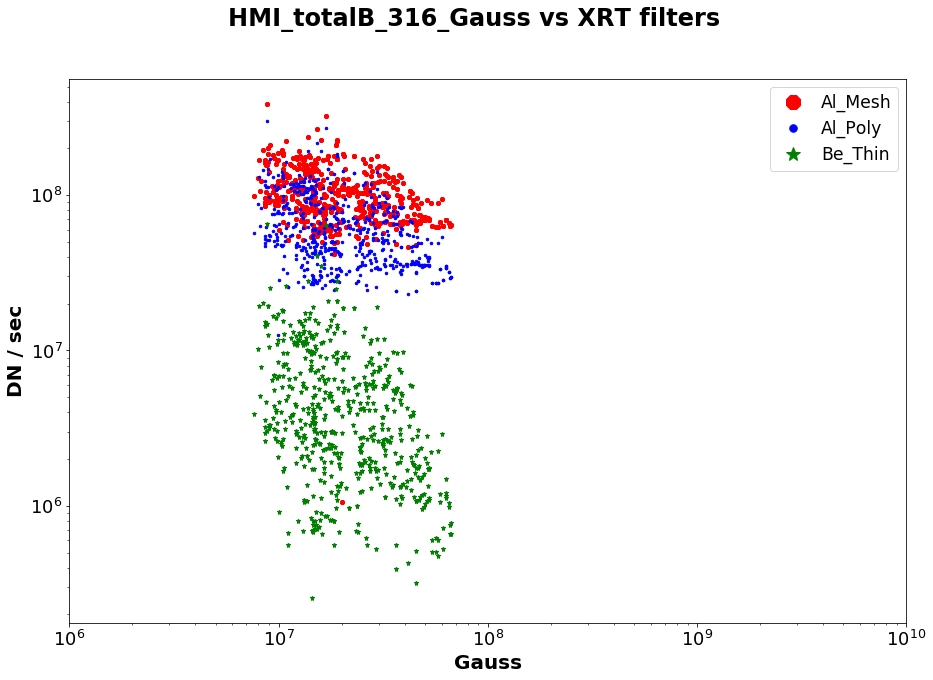

In [30]:
# Set figure
fig, ax1 = plt.subplots(1, figsize=(15,10)) # Comment out this line if you want to hide plot

# XRT filters
lns1 = ax1.plot(HMI_totB_316_Gauss_newYvals, Al_Mesh_newYvals, 'r8', markersize = 5, label = 'Al_Mesh')
lns2 = ax1.plot(HMI_totB_316_Gauss_newYvals, Al_Poly_newYvals, 'b.', markersize = 5, label = 'Al_Poly')
lns3 = ax1.plot(HMI_totB_316_Gauss_newYvals, Be_Thin_newYvals, 'g*', markersize = 5, label = 'Be_Thin')

# legend
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
leg = ax1.legend(lns, labs, loc=0, markerscale=3, fontsize=16)

# Axes formatting
ax1.set_xlabel('Gauss', fontsize=20, fontweight='bold')
ax1.set_ylabel('DN / sec', fontsize=20, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=18)
ax1.set_xscale('log')
ax1.set_xlim([1e6, 1e10])
ax1.yaxis.set_tick_params(labelsize=18)
ax1.set_yscale('log')
#ax1.set_ylim([0, 4.5e8])

plt.suptitle('HMI_totalB_316_Gauss vs XRT filters', fontsize=24, fontweight='bold')

# get the lines and texts inside legend box
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=6)
plt.setp(leg_texts, fontsize='xx-large')
#plt.grid(True, linewidth=2, which='major') # sets grid lines

plt.show()

## Plot HMI_totalB_316_Gauss (NORMALIZED) vs XRT filters

In [66]:
# Set figure
#fig, ax1 = plt.subplots(1, figsize=(15,10)) # Comment out this line if you want to hide plot

# XRT filters
lns1 = ax1.plot(HMI_totalB_316_Gauss_normalized, Al_Mesh_newYvals, 'r8', markersize = 5, label = 'Al_Mesh')
lns2 = ax1.plot(HMI_totalB_316_Gauss_normalized, Al_Poly_newYvals, 'b.', markersize = 5, label = 'Al_Poly')
lns3 = ax1.plot(HMI_totalB_316_Gauss_normalized, Be_Thin_newYvals, 'g*', markersize = 5, label = 'Be_Thin')

# legend
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
leg = ax1.legend(lns, labs, loc=0, markerscale=3, fontsize=16)

# Axes formatting
ax1.set_xlabel('HMI Normalized', fontsize=20, fontweight='bold')
ax1.set_ylabel('DN / sec', fontsize=20, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=18)
#ax1.set_xscale('log')
ax1.yaxis.set_tick_params(labelsize=18)
ax1.set_yscale('log')
#ax1.set_ylim([0, 4.5e8])

plt.suptitle('HMI_totalB_316_Gauss (NORMALIZED) vs XRT filters', fontsize=24, fontweight='bold')

# get the lines and texts inside legend box
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=6)
plt.setp(leg_texts, fontsize='xx-large')
#plt.grid(True, linewidth=2, which='major') # sets grid lines

plt.show()

<Figure size 432x288 with 0 Axes>

## Plot HMI_totalB_1000_Gauss vs XRT filters

In [67]:
# Set figure
#fig, ax1 = plt.subplots(1, figsize=(15,10)) # Comment out this line if you want to hide plot

# XRT filters
lns1 = ax1.plot(HMI_totB_1000_Gauss_newYvals, Al_Mesh_newYvals, 'r8', markersize = 5, label = 'Al_Mesh')
lns2 = ax1.plot(HMI_totB_1000_Gauss_newYvals, Al_Poly_newYvals, 'b.', markersize = 6, label = 'Al_Poly')
lns3 = ax1.plot(HMI_totB_1000_Gauss_newYvals, Be_Thin_newYvals, 'g*', markersize = 6, label = 'Be_Thin')

# legend
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
leg = ax1.legend(lns, labs, loc=0, markerscale=3, fontsize=16)

# Axes formatting
ax1.set_xlabel('Gauss', fontsize=20, fontweight='bold')
ax1.set_ylabel('DN / sec', fontsize=20, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=18)
ax1.set_xscale('log')
ax1.yaxis.set_tick_params(labelsize=18)
ax1.set_yscale('log')
#ax1.set_ylim([0, 4.5e8])

plt.suptitle('HMI_totalB_1000_Gauss vs XRT filters', fontsize=24, fontweight='bold')

# get the lines and texts inside legend box
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=6)
plt.setp(leg_texts, fontsize='xx-large')
#plt.grid(True, linewidth=2, which='major') # sets grid lines

plt.show()

<Figure size 432x288 with 0 Axes>

## Plot HMI_totalB_1000_Gauss (NORMALIZED) vs XRT filters

In [68]:
# Set figure
#fig, ax1 = plt.subplots(1, figsize=(15,10)) # Comment out this line if you want to hide plot

# XRT filters
lns1 = ax1.plot(HMI_totalB_1000_Gauss_normalized, Al_Mesh_newYvals, 'r8', markersize = 5, label = 'Al_Mesh')
lns2 = ax1.plot(HMI_totalB_1000_Gauss_normalized, Al_Poly_newYvals, 'b.', markersize = 6, label = 'Al_Poly')
lns3 = ax1.plot(HMI_totalB_1000_Gauss_normalized, Be_Thin_newYvals, 'g*', markersize = 6, label = 'Be_Thin')

# legend
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
leg = ax1.legend(lns, labs, loc=0, markerscale=3, fontsize=16)

# XRT and AIA axes formatting
ax1.set_xlabel('HMI Normalized', fontsize=20, fontweight='bold')
ax1.set_ylabel('DN / sec', fontsize=20, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=18)
ax1.set_xscale('log')
ax1.yaxis.set_tick_params(labelsize=18)
ax1.set_yscale('log')
#ax1.set_ylim([0, 4.5e8])

plt.suptitle('HMI_totalB_1000_Gauss (NORMALIZED) vs XRT filters', fontsize=24, fontweight='bold')

# get the lines and texts inside legend box
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=6)
plt.setp(leg_texts, fontsize='xx-large')
#plt.grid(True, linewidth=2, which='major') # sets grid lines

plt.show()

<Figure size 432x288 with 0 Axes>

In [69]:
#######################################################################################################################

In [70]:
#######################################################################################################################

# TIME SERIES PLOTS - HMI_total_B 316, 100 G and XRT Filters

## Plot HMI_totalB_316_Gauss and XRT filters

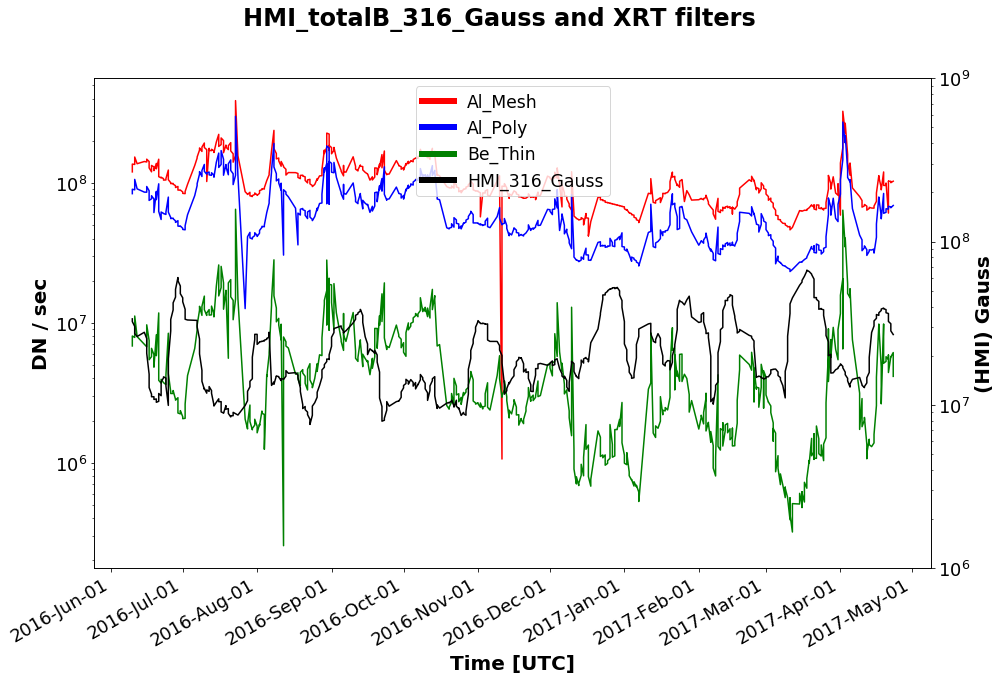

In [176]:
# Set figure
fig, ax1 = plt.subplots(1, figsize=(15,10)) # Comment out this line if you want to hide plot

# XRT filters
lns1 = ax1.plot(Be_Thin_daterange, Al_Mesh_newYvals, 'r-', markersize = 4, label = 'Al_Mesh')
lns2 = ax1.plot(Be_Thin_daterange, Al_Poly_newYvals, 'b-', markersize = 4, label = 'Al_Poly')
lns3 = ax1.plot(Be_Thin_daterange, Be_Thin_newYvals, 'g-', markersize = 4, label = 'Be_Thin')

# HMI_316_Gauss
ax2 = ax1.twinx()
lns4 = ax2.plot(Be_Thin_daterange, HMI_totB_316_Gauss_newYvals, 'k-', markersize = 3, label = 'HMI_316_Gauss')

# legend
lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
leg = ax1.legend(lns, labs, loc=9, fontsize=16)

# Format date on x-axis
fig.autofmt_xdate()
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%b-%d"))

# XRT axes formatting
ax1.set_xlabel('Time [UTC]', fontsize=20, fontweight='bold')
ax1.set_ylabel('DN / sec', fontsize=20, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax1.set_yscale('log')
#ax1.set_ylim([1e6, 1e9])

# HMI y-axis formatting
ax2.set_ylabel('(HMI) Gauss', fontsize=20, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yscale('log')
ax2.set_ylim([1e6, 1e9])

plt.suptitle('HMI_totalB_316_Gauss and XRT filters', fontsize=24, fontweight='bold')

# get the lines and texts inside legend box
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=6)
plt.setp(leg_texts, fontsize='xx-large')

plt.show()

## Plot HMI_totalB_316_Gauss (NORMALIZED) and XRT filters

In [75]:
# Set figure
#fig, ax1 = plt.subplots(1, figsize=(15,10)) # Comment out this line if you want to hide plot

# XRT filters
lns1 = ax1.plot(Be_Thin_daterange, Al_Mesh_newYvals, 'r-', markersize = 4, label = 'Al_Mesh')
lns2 = ax1.plot(Be_Thin_daterange, Al_Poly_newYvals, 'b-', markersize = 4, label = 'Al_Poly')
lns3 = ax1.plot(Be_Thin_daterange, Be_Thin_newYvals, 'g-', markersize = 4, label = 'Be_Thin')

# HMI_316_Gauss
ax2 = ax1.twinx()
lns4 = ax2.plot(Be_Thin_daterange, HMI_totalB_316_Gauss_normalized, 'k-', markersize = 3, label = 'HMI_316_Gauss')


# legend
lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
leg = ax1.legend(lns, labs, loc=9, fontsize=16)

# Format date on x-axis
fig.autofmt_xdate()
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%b-%d"))

# XRT axes formatting
ax1.set_xlabel('Time [UTC]', fontsize=20, fontweight='bold')
ax1.set_ylabel('DN / sec', fontsize=20, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax1.set_yscale('log')
#ax1.set_ylim([1e6, 1e9])

# HMI y-axis formatting
ax2.set_ylabel('HMI Normalized', fontsize=20, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=18)
#ax2.set_yscale('log')

plt.suptitle('HMI_totalB_316_Gauss (NORMALIZED) and XRT filters', fontsize=24, fontweight='bold')

# get the lines and texts inside legend box
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=6)
plt.setp(leg_texts, fontsize='xx-large')

plt.show()

<Figure size 432x288 with 0 Axes>

## Plot HMI_totalB_1000_Gauss and XRT filters

In [76]:
# Set figure
#fig, ax1 = plt.subplots(1, figsize=(15,10)) # Comment out this line if you want to hide plot

# XRT filters
lns1 = ax1.plot(Be_Thin_daterange, Al_Mesh_newYvals, 'r-', markersize = 4, label = 'Al_Mesh')
lns2 = ax1.plot(Be_Thin_daterange, Al_Poly_newYvals, 'b-', markersize = 4, label = 'Al_Poly')
lns3 = ax1.plot(Be_Thin_daterange, Be_Thin_newYvals, 'g-', markersize = 4, label = 'Be_Thin')

# HMI_316_Gauss
ax2 = ax1.twinx()
lns4 = ax2.plot(Be_Thin_daterange, HMI_totB_1000_Gauss_newYvals, 'tab:grey', markersize = 3, label = 'HMI_1000_Gauss')
#lns5 = ax2.plot(Be_Thin_daterange, HMIlosNeg_newYvals, 'c-X', markersize = 3, label = 'HMI_Neg_los')
#lns6 = ax2.plot(Be_Thin_daterange, HMIlosTot_newYvals, 'y-D', markersize = 3, label = 'HMI_Tot_los')

# legend
lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
leg = ax1.legend(lns, labs, loc=9, fontsize=16)

# Format date on x-axis
fig.autofmt_xdate()
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%b-%d"))

# XRT axes formatting
ax1.set_xlabel('Time [UTC]', fontsize=20, fontweight='bold')
ax1.set_ylabel('DN / sec', fontsize=20, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax1.set_yscale('log')
#ax1.set_ylim([1e6, 1e9])

# HMI y-axis formatting
ax2.set_ylabel('(HMI) Gauss', fontsize=20, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yscale('log')

plt.suptitle('HMI_totalB_1000_Gauss and XRT filters', fontsize=24, fontweight='bold')

# get the lines and texts inside legend box
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=6)
plt.setp(leg_texts, fontsize='xx-large')

plt.show()

<Figure size 432x288 with 0 Axes>

## Plot HMI_totalB_1000_Gauss (NORMALIZED) and XRT filters

In [77]:
# Set figure
#fig, ax1 = plt.subplots(1, figsize=(15,10)) # Comment out this line if you want to hide plot

# XRT filters
lns1 = ax1.plot(Be_Thin_daterange, Al_Mesh_newYvals, 'r-', markersize = 4, label = 'Al_Mesh')
lns2 = ax1.plot(Be_Thin_daterange, Al_Poly_newYvals, 'b-', markersize = 4, label = 'Al_Poly')
lns3 = ax1.plot(Be_Thin_daterange, Be_Thin_newYvals, 'g-', markersize = 4, label = 'Be_Thin')

# HMI_316_Gauss
ax2 = ax1.twinx()
lns4 = ax2.plot(Be_Thin_daterange, HMI_totalB_1000_Gauss_normalized, 'tab:grey', markersize = 3, label = 'HMI_1000_Gauss')

# legend
lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
leg = ax1.legend(lns, labs, loc=9, fontsize=16)

# Format date on x-axis
fig.autofmt_xdate()
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%b-%d"))

# XRT  axes formatting
ax1.set_xlabel('Time [UTC]', fontsize=20, fontweight='bold')
ax1.set_ylabel('DN / sec', fontsize=20, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=8)
ax1.set_yscale('log')
#ax1.set_ylim([1e6, 1e9])

# HMI y-axis formatting
ax2.set_ylabel('HMI Normalized', fontsize=20, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=18)
#ax2.set_yscale('log')

plt.suptitle('HMI_totalB_1000_Gauss (NORMALIZED) and XRT filters', fontsize=24, fontweight='bold')

# get the lines and texts inside legend box
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=6)
plt.setp(leg_texts, fontsize='xx-large')

plt.show()

<Figure size 432x288 with 0 Axes>

In [78]:
#######################################################################################################################

In [79]:
#######################################################################################################################

# HMI_los files

### Read in all HMI (line of sight) .sav files

In [188]:
# Read in all HMI (line of sight) .sav files
HMI_los_image_files = []
for name in glob.glob('hmi_los_data/image_sup_hmi_Blos_*.sav'):
    File_Name = readsav(name)
    HMI_los_image_files.append(File_Name)
    #print (name)

### Check original number of HMI_los files

In [189]:
# Check original number of HMI_los files
len(HMI_los_image_files)

525

# HMI_los_Pos_Gauss

### Check files for anomalies - Tot Pos Gauss

In [190]:
######## check files for anomalies in files ######
for t in range(len(HMI_los_image_files)):
    #print('For loop:', t)
    HMI_losFile = HMI_los_image_files[t]
    HMI_los_TotPosGauss = HMI_losFile.sdo_hmi_data_structure_supplement.total_positive_gauss_data
  
    #print(HMI_los_TotPosGauss)

# Only run This cell ONCE!!!! - Output should be 522

In [191]:
################## Only run This cell ONCE!!!! - Output should be 522 ################
BadIndicies = [35, 42, 74]
for Index in sorted(BadIndicies, reverse=True):
    del HMI_los_image_files[Index]
print(len(HMI_los_image_files))

522


### New Number of HMI los image .sav files

In [192]:
# New Number of HMI los image .sav files
N_HMI_los_image_files = len(HMI_los_image_files)
print(N_HMI_los_image_files)

522


# Only run ONE of the following TWO HMI_los Tot Pos Gauss cells!

### HMI_los Tot Pos Gauss - WITH OUTLIERS

In [153]:
## HMI los: Extract Pos_Data (Gauss) and Obs Date

HMIdateJDArray = []
HMIdatetimeArray = []

HMI_los_Pos_Gauss = []

for t in range(N_HMI_los_image_files):
    HMI_los_file = HMI_los_image_files[t]
    
#    # Get JD Obs date
    HMIjd = HMI_los_file.SDO_HMI_DATA_STRUCTURE_SUPPLEMENT.JD_TIME_ARRAY
    HMIdateJDfloat = float(HMIjd)   # Added
    HMIdateJDArray.append(HMIdateJDfloat)
    
    HMIdateArray = str(HMI_los_file)
    HMIdateArray[113:132]
    HMI_Date = HMIdateArray[113:132]
    HMIdatetime = [datetime.strptime(HMI_Date, "%Y-%m-%d"+'T'+"%H:%M:%S")]
#        #print(HMIdatetime)
HMItime = np.asarray(HMIdatetime)
HMIdatetimeArray.append(HMItime)
    
for t in range(N_HMI_los_image_files):
    HMI_los_file = HMI_los_image_files[t]  
    
    HMI_los_TotPosGauss = HMI_los_file.sdo_hmi_data_structure_supplement.total_positive_gauss_data
    HMIlosPosfloat = float(HMI_los_TotPosGauss)   # Added for interpolation purposes
    HMI_los_Pos_Gauss.append(HMIlosPosfloat)
##print(HMI_los_Pos_Gauss)

### HMI_los Tot Pos Gauss - EXCLUDING OUTLIERS

In [86]:
# HMI los: EXCLUDE OUTLIERS and Extract Pos_Data (Gauss) and Obs Date

HMI_los_Pos_Gauss = []

for t in range(N_HMI_los_image_files):
    HMI_los_file = HMI_los_image_files[t]  
    
    HMI_los_TotPosGauss = HMI_los_file.sdo_hmi_data_structure_supplement.total_positive_gauss_data
    HMIlosPosfloat = float(HMI_los_TotPosGauss)   # Added for interpolation purposes
    HMI_los_Pos_Gauss.append(HMIlosPosfloat)
#print(HMI_los_Pos_Gauss)
#len(HMI_los_Pos_Gauss)

#Exclude Outliers > 1e7 (Loop: 68, 226, 352, 365, 503)
HMI_Pos_los_modified = []
HMIdateJDArray = []
HMIdatetimeArray = []

for t in range(N_HMI_los_image_files):
    if HMI_los_Pos_Gauss[t] < 0.6e8:
        HMI_Pos_Include = HMI_los_Pos_Gauss[t]
        #print('\n'+'Loop number:', t)
        #print(HMI_Pos_Include)
        HMI_Pos_los_modified.append(HMI_Pos_Include)
        
        # Get JD Obs date
        HMI_los_file = HMI_los_image_files[t]
        HMIjd = HMI_los_file.SDO_HMI_DATA_STRUCTURE_SUPPLEMENT.JD_TIME_ARRAY
        HMIdateJDfloat = float(HMIjd)   # Added
        HMIdateJDArray.append(HMIdateJDfloat)
    
        HMIdateArray = str(HMI_los_file)
        HMIdateArray[113:132]
        HMI_Date = HMIdateArray[113:132]
        HMIdatetime = [datetime.strptime(HMI_Date, "%Y-%m-%d"+'T'+"%H:%M:%S")]
            #print(HMIdatetime)
        HMItime = np.asarray(HMIdatetime)
        HMIdatetimeArray.append(HMItime)
        
N_Modified_HMI_Pos_los = len(HMI_Pos_los_modified)


### Interpolate

In [87]:
# Interpolate HMI_los Pos data to XRT Be_Thin dates (ONLY use with HMI_los_Pos_Gauss EXCLUDING OUTLIERS)
HMIlosPos_arr = np.asarray(HMI_Pos_los_modified)
HMIlosPos_1d =(HMIlosPos_arr).flatten()
HMIlosPos_newYvals = np.interp(XRT_Be_Thin_dateJD, HMIdateJDArray, HMIlosPos_1d)
#print(HMIlosPos_newYvals)

### Normalize

In [88]:
# Normalize HMI_Pos_los with Outliers excluded (ONLY use with HMI_los_Pos_Gauss EXCLUDING OUTLIERS)
# Method 1:
data_frame = pd.DataFrame(HMIlosPos_newYvals)
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data_frame)
data_frame_normalized = pd.DataFrame(np_scaled)
HMI_los_Pos_normalized = data_frame_normalized

## HMI_los_Neg_Gauss

In [89]:
# HMI los: Extract Neg_Data (Gauss)

HMI_los_Neg_Gauss = []
HMI_los_min_Neg = []
    
for t in range(N_HMI_los_image_files):
    HMI_los_file = HMI_los_image_files[t]

        # HMI los total negative gauss scaled values
    HMI_los_TotNegGauss = HMI_los_file.sdo_hmi_data_structure_supplement.total_negative_gauss_data
    HMI_los_abs_val_NegGauss = abs(HMI_los_TotNegGauss)
    HMIlosNegfloat = float(HMI_los_abs_val_NegGauss)   # Added for interpolation purposes
    HMI_los_Neg_Gauss.append(HMIlosNegfloat)
#print(HMI_los_Neg_Gauss)

### Interpolate

In [154]:
# Interpolate HMI_los Neg data to XRT Be_Thin dates (only work with HMI_los_Pos_Gauss WITH OUTLIERS)
HMIlosNeg_arr = np.asarray(HMI_los_Neg_Gauss)
HMIlosNeg_1d =(HMIlosNeg_arr).flatten()
HMIlosNeg_newYvals = np.interp(XRT_Be_Thin_dateJD, HMIdateJDArray, HMIlosNeg_1d)
#print(HMIlosNeg_newYvals)

### Normalize

In [155]:
# Normalize HMI_Neg_los with Outliers excluded
# Method 1:
data_frame = pd.DataFrame(HMIlosNeg_newYvals)
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data_frame)
data_frame_normalized = pd.DataFrame(np_scaled)
HMI_los_Neg_normalized = data_frame_normalized

### Read in # of Pos and Neg Pixels and Determine Ratio

In [92]:
######## Read in # of Pos and Neg Pixels and Determine Ratio ######
PosPix = []
NegPix = []
Ratio_Pos2Neg_Pix = []
Ratio_Pos_Pix = []
Ratio_Neg_Pix = []

for t in range(len(HMI_los_image_files)):
    #print('For loop:', t)
    HMI_losFile = HMI_los_image_files[t]
    HMI_los_TotPosPix = HMI_losFile.sdo_hmi_data_structure_supplement.n_pixels_total_positive_gauss_data
    HMI_los_TotNegPix = HMI_losFile.sdo_hmi_data_structure_supplement.n_pixels_total_negative_gauss_data
    
    Tot_Pix_Ratio = HMI_los_TotPosPix/HMI_los_TotNegPix
    TotRatioFloat = float(Tot_Pix_Ratio)
    Ratio_Pos2Neg_Pix.append(TotRatioFloat)
    
    PosPix.append(HMI_los_TotPosPix)
    NegPix.append(HMI_los_TotNegPix)
    
    # Get Ratio of Pos_Gauss / N_Pos_Pixels
    Pos_Pix_Ratio = (HMI_los_Pos_Gauss[t])/HMI_los_TotPosPix
    PosRatioFloat = float(Pos_Pix_Ratio)
    Ratio_Pos_Pix.append(PosRatioFloat)
    
     # Get Ratio of Neg_Gauss / N_Neg_Pixels
    Neg_Pix_Ratio = (HMI_los_Neg_Gauss[t])/HMI_los_TotNegPix
    NegRatioFloat = float(Neg_Pix_Ratio)
    Ratio_Neg_Pix.append(NegRatioFloat)
    
##Determine Mean of the Ratio of N_Pos_Pixles / N_Neg_Pixles 
PosPixMean = np.average(PosPix)
#print(PosPixMean)
NegPixMean = np.average(NegPix)
#print(NegPixMean)
TotPixMean = np.average(Ratio_Pos2Neg_Pix)
print(TotPixMean)

0.34828545722437926


In [93]:
#######################################################################################################################

In [94]:
#######################################################################################################################

# SCATTER PLOTS

## Plot Ratio_Pos_Pix vs Ratio_Neg_Pix

In [195]:
# Set figure
#fig, ax1 = plt.subplots(1, figsize=(15,10))

# HMI_los
lns1 = ax1.plot(Ratio_Pos_Pix, Ratio_Neg_Pix, 'g8', markersize = 4, label = 'HMI_los')

# legend
lns = lns1
labs = [l.get_label() for l in lns]
leg = ax1.legend(lns, labs, loc=1, fontsize=16)

# XRT and AIA axes formatting
ax1.set_xlabel('HMI_Pos Gauss', fontsize=16, fontweight='bold')
ax1.set_ylabel('HMI_Neg Gauss', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.set_xscale('log')
ax1.yaxis.set_tick_params(labelsize=14)
ax1.set_yscale('log')
#ax1.set_ylim([0, 4.5e8])


plt.suptitle('HMI_los_Pos vs HMI_los_Neg (Gauss)', fontsize=16, fontweight='bold')

# get the lines and texts inside legend box
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=6)
plt.setp(leg_texts, fontsize='x-large')

plt.figure(figsize=(15,10))

plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

### Normalize

In [99]:
# Normalize Ratio_Pos_Pix
# Method 1:
data_frame = pd.DataFrame(Ratio_Pos_Pix)
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data_frame)
data_frame_normalized = pd.DataFrame(np_scaled)
Ratio_Pos_Pix_normalized = data_frame_normalized

# Normalize Ratio_Neg_Pix
# Method 1:
data_frame = pd.DataFrame(Ratio_Neg_Pix)
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data_frame)
data_frame_normalized = pd.DataFrame(np_scaled)
Ratio_Neg_Pix_normalized = data_frame_normalized

## HMI_los_Tot_Gauss

In [100]:
# HMI los: Find Total (Gauss) Data by Summing Pos and Neg

HMI_los_Tot_Sum = []

for t in range(N_HMI_los_image_files):
    HMI_los_TotGauss = HMI_los_Pos_Gauss[t] + HMI_los_Neg_Gauss[t]
    HMIlosTotfloat = float(HMI_los_TotGauss)   # Added for interpolation purposes
    HMI_los_Tot_Sum.append(HMIlosTotfloat)
#print(HMI_los_Tot_Sum)

### Interpolate

In [101]:
# Interpolate HMI_los Tot Unsigned Gauss data to XRT Be_Thin dates (only work with HMI_los_Pos_Gauss WITH OUTLIERS)
HMIlosTot_arr = np.asarray(HMI_los_Tot_Sum)
HMIlosTot_1d =(HMIlosTot_arr).flatten()
HMIlosTot_newYvals = np.interp(XRT_Be_Thin_dateJD, HMIdateJDArray, HMIlosTot_1d)
#print(HMIlosTot_newYvals)

ValueError: fp and xp are not of the same length.

In [102]:
#######################################################################################################################

In [103]:
#######################################################################################################################

# SCATTER PLOTS

## Plot HMI_los_Pos vs HMI_los_Neg

In [105]:
# Set figure
#fig, ax1 = plt.subplots(1, figsize=(15,10))

# HMI_los
lns1 = ax1.plot(HMI_los_Pos_Gauss, HMI_los_Neg_Gauss, 'g8', markersize = 4, label = 'HMI_los')

# legend
lns = lns1
labs = [l.get_label() for l in lns]
leg = ax1.legend(lns, labs, loc=1, fontsize=16)

# XRT and AIA axes formatting
ax1.set_xlabel('HMI_Pos Gauss', fontsize=16, fontweight='bold')
ax1.set_ylabel('HMI_Neg Gauss', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.set_xscale('log')
ax1.yaxis.set_tick_params(labelsize=14)
ax1.set_yscale('log')
#ax1.set_ylim([0, 4.5e8])


plt.suptitle('HMI_los_Pos vs HMI_los_Neg (Gauss)', fontsize=16, fontweight='bold')

# get the lines and texts inside legend box
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=6)
plt.setp(leg_texts, fontsize='x-large')

plt.figure(figsize=(15,10))

plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

In [106]:
#######################################################################################################################

In [107]:
#######################################################################################################################

# HMI_total_B (vector) files

In [108]:
HMI_totalB_vector_files = []
for name in glob.glob('hmi_vector/supplemental_data/*.sav'):
    File_Name = readsav(name)
    HMI_totalB_vector_files.append(File_Name)
    #print (name)

### Number of HMI_totalB_vector .sav files

In [109]:
# Number of HMI_totalB_vector .sav files
N_HMI_totalB_vector_files = len(HMI_totalB_vector_files)
print(N_HMI_totalB_vector_files)

474


In [110]:
HMItotalB_factor = 1.0e-2
HMItotalB_offset = 1.0e2

HMI_totalB_vector_dateJDArray = []
HMI_totalB_vector_datetimeArray = []
HMI_totalB_vector_values = []
FindHMI_totalB_vector_min = []
for t in range(N_HMI_totalB_vector_files):
    HMIfile = HMI_totalB_vector_files[t]
    
    HMItotalBgauss = HMIfile.sdo_hmi_data_structure_supplement.b_total[0].total_gauss_data_data
    FindHMI_totalB_vector_min.append(HMItotalBgauss)
    
for t in range(N_HMI_totalB_vector_files):
    HMIfile = HMI_totalB_vector_files[t]
    
    #Added to get JD
    HMIjd = HMIfile.sdo_hmi_data_structure_supplement.b_total[0].JD_TIME_ARRAY
    HMIdateJDfloat = float(HMIjd)   # Added

    HMI_totalB_vector_dateJDArray.append(HMIdateJDfloat)
    
    HMI_totalB_vector_gauss = HMIfile.sdo_hmi_data_structure_supplement.b_total[0].total_gauss_data_data
    ScaledHMItotalB = ((HMItotalB_factor*(HMI_totalB_vector_gauss - min(FindHMI_totalB_vector_min))) + HMItotalB_offset)
    
    HMI_totalB_vector_float = float(ScaledHMItotalB)   # Added for interpolation purposes

    HMI_totalB_vector_values.append(HMI_totalB_vector_float)

### Interpolate

In [111]:
# Interpolate HMI_totalB_vector data to XRT Be_Thin dates
HMI_totalB_vector_arr = np.asarray(HMI_totalB_vector_values)
HMI_totalB_vector_1d =(HMI_totalB_vector_arr).flatten()
HMI_totalB_vector_newYvals = np.interp(XRT_Be_Thin_dateJD, HMI_totalB_vector_dateJDArray, HMI_totalB_vector_1d)
#print(HMI_totalB_vector_newYvals)

### Normalize

In [112]:
# Normalize HMI_totalB_vector values
# Method 1:
data_frame = pd.DataFrame(HMI_totalB_vector_newYvals)
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data_frame)
data_frame_normalized = pd.DataFrame(np_scaled)
HMI_totalB_vector_normalized = data_frame_normalized

In [113]:
#######################################################################################################################

In [114]:
#######################################################################################################################

# AIA Filters - 94A and FeXVIII

## AIA 94A files

### Read in AIA 94A files

In [115]:
# Read in AIA 94A files
AIA94A_files = []
for name in glob.glob('94A/supplement_data/*.sav'):
    File_Name = readsav(name)
    AIA94A_files.append(File_Name)
    #print (name)

### Number of AIA_94A .sav files

In [116]:
# Number of AIA_94A .sav files
N_AIA94A_files = len(AIA94A_files)
print(N_AIA94A_files)

549


### Extract correct JD Obs Date

In [196]:
# Extract correct JD Obs Date

AIA94A_JDArray = []
AIA94A_ObsDate = []

for t in range(N_AIA94A_files):
    AIA_94Afile = AIA94A_files[t]
    
    JDtimeArray = AIA_94Afile.sdo_aia_data_structure_supplement.JD_TIME_ARRAY
    # Check - only extract one date
    if len(JDtimeArray[0]) == 2:
        JDtimeArray = JDtimeArray[0][0]
        
    JDtimeFloat = float(JDtimeArray)
    AIA94A_JDArray.append(JDtimeFloat)
    
    # Convert from JD to UTC
    ObsDate = Time(JDtimeFloat, format='jd', scale='utc')
    #ObsDate = jd.datetime(JDtimeArray)  
    #print(ObsDate)
    AIA94A_ObsDate.append(ObsDate)

2457550.2722222228
2457550.7516666674
2457551.253055556
2457551.769722223
2457555.259027778
2457555.691944445
2457556.2429166674
2457556.756527778
2457557.252361112
2457557.673194445
2457558.2648611115
2457558.754444445
2457559.2486111117
2457559.6537500005
2457560.2572222226
2457560.7363888896
2457561.270416667
2457561.750277778
2457562.2537500006
2457562.768055556
2457563.281527778
2457563.7537500006
2457564.235416667
2457564.699027778
2457565.2551388894
2457565.7738888892
2457566.2575000008
2457566.748194445
2457567.2412500004
2457567.7548611118
2457568.2509722225
2457568.7291666674
2457569.2634722227
2457569.753055556
2457570.247222223
2457570.7604166674
2457571.255833334
2457571.7822222225
2457572.271805556
2457572.7488888893
2457576.253715278
2457576.771805556
2457577.2561111115
2457577.746805556
2457578.2398611116
2457578.753055556
2457579.2495833337
2457579.7773611117
2457580.261666667
2457580.752361112
2457581.245694445
2457581.758333334
2457582.254444445
2457582.7336111115
24

### Check number of Dates 

In [118]:
# Check number of Dates 
len(AIA94A_ObsDate)

549

### Extract AIA 94A data and format dates (not needed for plots)

In [119]:
# Extract AIA 94A data and format dates (not needed for plots)
AIA_94A_total_positive_counts_data = []
AIA_94A_FOV_ARCSECONDS = []
AIA_94A_N_PIXELS_POSITIVE_COUNTS_DATA =[]
AIA_94A_N_TOTAL_PIXELS = []

AIA_94A_factor = 1.0e6

# Extract AIA 94A data
for t in range(N_AIA94A_files):
    AIA_94Afile = AIA94A_files[t]
    
    TotPosCounts = AIA_94Afile.sdo_aia_data_structure_supplement.total_positive_counts_data
    AIA_94A_total_positive_counts_data.append(TotPosCounts)
    
    FOVarcsec = AIA_94Afile.sdo_aia_data_structure_supplement.FOV_ARCSECONDS
    AIA_94A_FOV_ARCSECONDS.append(FOVarcsec)
    
    NPixPosCounts = AIA_94Afile.sdo_aia_data_structure_supplement.N_PIXELS_POSITIVE_COUNTS_DATA
    AIA_94A_N_PIXELS_POSITIVE_COUNTS_DATA.append(NPixPosCounts)
    
    NTotPix = AIA_94Afile.sdo_aia_data_structure_supplement.N_TOTAL_PIXELS
    AIA_94A_N_TOTAL_PIXELS.append(NTotPix)

# Extract date range 
N_AIA94A_files1 = 423
AIA_94AdatetimeArray = []
ScaledAIA94A = []

for t in range(N_AIA94A_files):
    #print("Loop Number", t)
    if t < N_AIA94A_files1 + 1:
        AIA_94Afile = AIA94A_files[t]
    
        AIA_94AdateArray = str(AIA_94Afile)
        AIA_94AdateArray[108:127]
        AIA_94A_Date = AIA_94AdateArray[108:127]
        AIA_94Adatetime = [datetime.strptime(AIA_94A_Date, "%Y-%m-%d"+'T'+"%H:%M:%S")]

    
    else:
        AIA_94Afile = AIA94A_files[t]
    
        AIA_94AdateArray = str(AIA_94Afile)
        AIA_94AdateArray[107:126]
        AIA_94A_Date = AIA_94AdateArray[107:126]
        AIA_94Adatetime = [datetime.strptime(AIA_94A_Date, "%Y-%m-%d"+'T'+"%H:%M:%S")]

    
    #print(AIA_94Adatetime)
    AIA_94A_time = np.asarray(AIA_94Adatetime)
    #AIA_94A_time = np.asarray(AIA_94AdatetimeYMD[0])
    AIA_94AdatetimeArray.append(AIA_94A_time)
    
    TotPosCounts = AIA_94Afile.sdo_aia_data_structure_supplement[0].total_positive_counts_data
    FOVarcsec = AIA_94Afile.sdo_aia_data_structure_supplement[0].FOV_ARCSECONDS
    NPixPosCounts = AIA_94Afile.sdo_aia_data_structure_supplement[0].N_PIXELS_POSITIVE_COUNTS_DATA
    NTotPix = AIA_94Afile.sdo_aia_data_structure_supplement[0].N_TOTAL_PIXELS
    
    # Avoid anomolies in data, like double values in array
    if len(TotPosCounts) == 2:
        TotPosCounts = TotPosCounts[0]
    if len(FOVarcsec) == 2:
        FOVarcsec = FOVarcsec[0]
    if len(NPixPosCounts) == 2:
        NPixPosCounts = NPixPosCounts[0]
    if len(NTotPix) == 2:
        NTotPix = NTotPix[0]   
    
    NormalizedAIA94A = (((TotPosCounts)/((FOVarcsec)*(NPixPosCounts/NTotPix)))*AIA_94A_factor)
    AIA_94Afloat = float(NormalizedAIA94A)   # Added for interpolation purposes
    ScaledAIA94A.append(AIA_94Afloat)

### Interpolate

In [120]:
# Interpolate AIA 94A data to XRT Be_Thin dates
AIA94A_arr = np.asarray(ScaledAIA94A)
AIA94A_1d =(AIA94A_arr).flatten()
AIA94A_newYvals = np.interp(XRT_Be_Thin_dateJD, AIA94A_JDArray, AIA94A_1d)
#print(AIA94A_newYvals)

### Normalize

In [121]:
# Normalize AIA 94A values
# Method 1:
data_frame = pd.DataFrame(AIA94A_newYvals)
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data_frame)
data_frame_normalized = pd.DataFrame(np_scaled)
AIA_94A_normalized = data_frame_normalized

## AIA FeXVIII files

### Read in AIA FeXVIII files

In [122]:
# Read in AIA FeXVIII files
FeXVIII_files = []
for name in glob.glob('FeXVIII/supplemental_data/*.sav'):
    File_Name = readsav(name)
    FeXVIII_files.append(File_Name)
    #print (name)

### Number of FeXVIII_94A .sav files

In [123]:
# Number of FeXVIII_94A .sav files
N_FeXVIII_files = len(FeXVIII_files)
print(N_FeXVIII_files)

549


### Extract correct JD Obs Date

In [124]:
# Extract correct JD Obs Date

AIAFeXVIII_JDArray = []
AIAFeXVIII_ObsDate = []

for t in range(N_FeXVIII_files):
    AIA_FeXVIII_file = FeXVIII_files[t]
    
    JDtimeArray = AIA_FeXVIII_file.sdo_aia_data_structure_supplement.JD_TIME_ARRAY
    # Check - only extract one date
    if len(JDtimeArray[0]) == 2:
        JDtimeArray = JDtimeArray[0][0]
        
    JDtimeFloat = float(JDtimeArray)
    AIAFeXVIII_JDArray.append(JDtimeFloat)
    
    # Convert from JD to UTC
    ObsDate = Time(JDtimeFloat, format='jd', scale='utc')
    #ObsDate = jd.datetime(JDtimeArray)  
    #print(ObsDate)
    AIAFeXVIII_ObsDate.append(ObsDate)

### Extract AIA FeXVIII data and format dates (format dates - not needed for plots)

In [125]:
# Extract AIA FeXVIII data and format dates (format dates - not needed for plots)
FeXVIII_total_positive_counts_data = []
FeXVIII_FOV_ARCSECONDS = []
FeXVIII_N_PIXELS_POSITIVE_COUNTS_DATA =[]
FeXVIII_N_TOTAL_PIXELS = []

FeXVIII_factor = 1.0e6

# Extract date range 
N_FeXVIII_files1 = 423
FeXVIII_datetimeArray = []
ScaledFeXVIII = []

for t in range(N_FeXVIII_files):
    #print("Loop Number", t)
    if t < N_FeXVIII_files1 + 1:
        FeXVIII_file = FeXVIII_files[t]
    
        FeXVIIIdateArray = str(FeXVIII_file)
        FeXVIIIdateArray[106:125]
        FeXVIII_Date = FeXVIIIdateArray[106:125]
        FeXVIIIdatetime = [datetime.strptime(FeXVIII_Date, "%Y-%m-%d"+'T'+"%H:%M:%S")]

    
    else:
        FeXVIII_file = FeXVIII_files[t]
    
        FeXVIIIdateArray = str(FeXVIII_file)
        FeXVIIIdateArray[105:124]
        FeXVIII_Date = FeXVIIIdateArray[105:124]
        FeXVIIIdatetime = [datetime.strptime(FeXVIII_Date, "%Y-%m-%d"+'T'+"%H:%M:%S")]

    
    #print(FeXVIIIdatetime)
    FeXVIII_time = np.asarray(FeXVIIIdatetime)
    FeXVIII_datetimeArray.append(FeXVIII_time)
    
    TotPosCounts = FeXVIII_file.sdo_aia_data_structure_supplement[0].total_positive_counts_data
    FOVarcsec = FeXVIII_file.sdo_aia_data_structure_supplement[0].FOV_ARCSECONDS
    NPixPosCounts = FeXVIII_file.sdo_aia_data_structure_supplement[0].N_PIXELS_POSITIVE_COUNTS_DATA
    NTotPix = FeXVIII_file.sdo_aia_data_structure_supplement[0].N_TOTAL_PIXELS
    
    # Avoid anomolies in data, like double values in array
    if len(TotPosCounts) == 2:
        TotPosCounts = TotPosCounts[0]
    if len(FOVarcsec) == 2:
        FOVarcsec = FOVarcsec[0]
    if len(NPixPosCounts) == 2:
        NPixPosCounts = NPixPosCounts[0]
    if len(NTotPix) == 2:
        NTotPix = NTotPix[0]   
    
    NormalizedFeXVIII = (((TotPosCounts)/((FOVarcsec)*(NPixPosCounts/NTotPix)))*FeXVIII_factor)
    AIA_FeXVIIIfloat = float(NormalizedFeXVIII)   # Added for interpolation purposes
    ScaledFeXVIII.append(AIA_FeXVIIIfloat)

### Interpolate

In [126]:
# Interpolate AIA FeXVIII data to XRT Be_Thin dates
AIA_FeXVIII_arr = np.asarray(ScaledFeXVIII)
AIA_FeXVIII_1d =(AIA_FeXVIII_arr).flatten()
AIA_FeXVIII_newYvals = np.interp(XRT_Be_Thin_dateJD, AIAFeXVIII_JDArray, AIA_FeXVIII_1d)
#print(AIA_FeXVIII_newYvals)

### Normalize

In [127]:
# Normalize AIA FeXVIII values
# Method 1:
data_frame = pd.DataFrame(AIA_FeXVIII_newYvals)
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data_frame)
data_frame_normalized = pd.DataFrame(np_scaled)
AIA_FeXVIII_normalized = data_frame_normalized

In [128]:
#######################################################################################################################

In [129]:
#######################################################################################################################

# SCATTER PLOTS

## Plot HMI_los_316_Gauss vs XRT and AIA filters

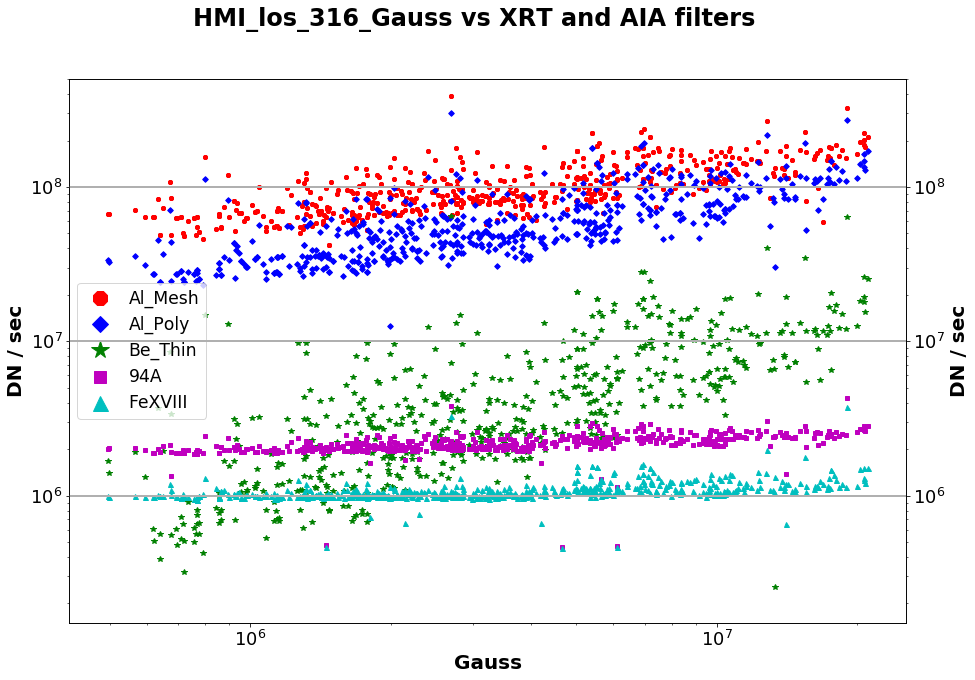

In [130]:
# Set figure
fig, ax1 = plt.subplots(1, figsize=(15,10)) # Comment out this line if you want to hide plot

# XRT filters
lns1 = ax1.plot(HMI_los_316_Gauss_newYvals, Al_Mesh_newYvals, 'r8', markersize = 5, label = 'Al_Mesh')
lns2 = ax1.plot(HMI_los_316_Gauss_newYvals, Al_Poly_newYvals, 'bD', markersize = 4, label = 'Al_Poly')
lns3 = ax1.plot(HMI_los_316_Gauss_newYvals, Be_Thin_newYvals, 'g*', markersize = 6, label = 'Be_Thin')

# AIA filters
lns4 = ax1.plot(HMI_los_316_Gauss_newYvals, AIA94A_newYvals, 'ms', markersize = 4, label = '94A')
lns5 = ax1.plot(HMI_los_316_Gauss_newYvals, AIA_FeXVIII_newYvals, 'c^', markersize = 5, label = 'FeXVIII')

ax2 = ax1.twinx()

# legend
lns = lns1+lns2+lns3+lns4+lns5
labs = [l.get_label() for l in lns]
leg = ax1.legend(lns, labs, loc=0, markerscale=3, fontsize=16)

# XRT and AIA axes formatting
ax1.set_xlabel('Gauss', fontsize=20, fontweight='bold')
ax1.set_ylabel('DN / sec', fontsize=20, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=18)
ax1.set_xscale('log')
ax1.yaxis.set_tick_params(labelsize=18)
ax1.set_yscale('log')
ax1.set_ylim([1.5e5, 0.5e9])

# HMI y-axis formatting
ax2.set_ylabel('DN / sec', fontsize=20, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yscale('log')
ax2.set_ylim([1.5e5, 0.5e9])

plt.suptitle('HMI_los_316_Gauss vs XRT and AIA filters', fontsize=24, fontweight='bold')

# get the lines and texts inside legend box
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=6)
plt.setp(leg_texts, fontsize='xx-large')
plt.grid(True, linewidth=2, which='major')
#plt.hlines(2e6,0.15e6,2e7)

plt.show()

## Plot HMI_totalB_316_Gauss vs XRT and AIA filters

In [199]:
# Set figure
#fig, ax1 = plt.subplots(1, figsize=(15,10)) # Comment out this line if you want to hide plot

# XRT filters
lns1 = ax1.plot(HMI_totB_316_Gauss_newYvals, Al_Mesh_newYvals, 'r8', markersize = 5, label = 'Al_Mesh')
lns2 = ax1.plot(HMI_totB_316_Gauss_newYvals, Al_Poly_newYvals, 'b.', markersize = 4, label = 'Al_Poly')
lns3 = ax1.plot(HMI_totB_316_Gauss_newYvals, Be_Thin_newYvals, 'g*', markersize = 6, label = 'Be_Thin')

# AIA filters
lns4 = ax1.plot(HMI_totB_316_Gauss_newYvals, AIA94A_newYvals, 'ms', markersize = 4, label = '94A')
lns5 = ax1.plot(HMI_totB_316_Gauss_newYvals, AIA_FeXVIII_newYvals, 'c^', markersize = 5, label = 'FeXVIII')

ax2 = ax1.twinx()

# legend
lns = lns1+lns2+lns3+lns4+lns5
labs = [l.get_label() for l in lns]
leg = ax1.legend(lns, labs, loc=0, markerscale=3, fontsize=16)

# XRT and AIA axes formatting
ax1.set_xlabel('Gauss', fontsize=20, fontweight='bold')
ax1.set_ylabel('DN / sec', fontsize=20, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=18)
ax1.set_xscale('log')
ax1.yaxis.set_tick_params(labelsize=18)
ax1.set_yscale('log')
#ax1.set_ylim([0, 4.5e8])

# HMI y-axis formatting
ax2.set_ylabel('DN / sec', fontsize=20, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yscale('log')
ax2.set_ylim([1.5e5, 0.5e9])

plt.suptitle('HMI_totalB_316_Gauss vs XRT and AIA filters', fontsize=24, fontweight='bold')

# get the lines and texts inside legend box
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=6)
plt.setp(leg_texts, fontsize='xx-large')
#plt.grid(True, linewidth=2, which='major')

plt.show()

<Figure size 432x288 with 0 Axes>

## Plot HMI_los_1000_Gauss vs XRT and AIA filters

In [200]:
# Set figure
#fig, ax1 = plt.subplots(1, figsize=(15,10)) # Comment out this line if you want to hide plot

# XRT filters
lns1 = ax1.plot(HMI_los_1000_Gauss_newYvals, Al_Mesh_newYvals, 'r8', markersize = 5, label = 'Al_Mesh')
lns2 = ax1.plot(HMI_los_1000_Gauss_newYvals, Al_Poly_newYvals, 'b.', markersize = 4, label = 'Al_Poly')
lns3 = ax1.plot(HMI_los_1000_Gauss_newYvals, Be_Thin_newYvals, 'g*', markersize = 6, label = 'Be_Thin')

# AIA filters
lns4 = ax1.plot(HMI_los_1000_Gauss_newYvals, AIA94A_newYvals, 'm+', markersize = 4, label = '94A')
lns5 = ax1.plot(HMI_los_1000_Gauss_newYvals, AIA_FeXVIII_newYvals, 'c^', markersize = 5, label = 'FeXVIII')

ax2 = ax1.twinx()

# legend
lns = lns1+lns2+lns3+lns4+lns5
labs = [l.get_label() for l in lns]
leg = ax1.legend(lns, labs, loc=0, markerscale=3, fontsize=16)

# XRT and AIA axes formatting
ax1.set_xlabel('Gauss', fontsize=20, fontweight='bold')
ax1.set_ylabel('DN / sec', fontsize=20, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=18)
ax1.set_xscale('log')
ax1.set_xlim([1e5, 1e7])

ax1.yaxis.set_tick_params(labelsize=18)
ax1.set_yscale('log')
#ax1.set_ylim([0, 4.5e8])

# HMI y-axis formatting
ax2.set_ylabel('DN / sec', fontsize=20, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yscale('log')
ax2.set_ylim([1.5e5, 0.5e9])

plt.suptitle('HMI_los_1000_Gauss vs XRT and AIA filters', fontsize=24, fontweight='bold')

# get the lines and texts inside legend box
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=6)
plt.setp(leg_texts, fontsize='xx-large')
#plt.grid(True, linewidth=2, which='major')

plt.show()

<Figure size 432x288 with 0 Axes>

## Plot HMI_totalB_1000_Gauss vs XRT and AIA filters

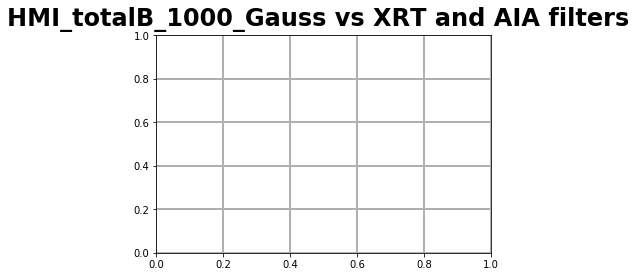

In [133]:
# Set figure
#fig, ax1 = plt.subplots(1, figsize=(15,10)) # Comment out this line if you want to hide plot

# XRT filters
lns1 = ax1.plot(HMI_totB_1000_Gauss_newYvals, Al_Mesh_newYvals, 'r8', markersize = 5, label = 'Al_Mesh')
lns2 = ax1.plot(HMI_totB_1000_Gauss_newYvals, Al_Poly_newYvals, 'b.', markersize = 4, label = 'Al_Poly')
lns3 = ax1.plot(HMI_totB_1000_Gauss_newYvals, Be_Thin_newYvals, 'g*', markersize = 6, label = 'Be_Thin')

# AIA filters
lns4 = ax1.plot(HMI_totB_1000_Gauss_newYvals, AIA94A_newYvals, 'ms', markersize = 4, label = '94A')
lns5 = ax1.plot(HMI_totB_1000_Gauss_newYvals, AIA_FeXVIII_newYvals, 'c^', markersize = 5, label = 'FeXVIII')

ax2 = ax1.twinx()

# legend
lns = lns1+lns2+lns3+lns4+lns5
labs = [l.get_label() for l in lns]
leg = ax1.legend(lns, labs, loc=0, markerscale=3, fontsize=16)

# XRT and AIA axes formatting
ax1.set_xlabel('Gauss', fontsize=20, fontweight='bold')
ax1.set_ylabel('DN / sec', fontsize=20, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=18)
ax1.set_xscale('log')
ax1.set_xlim([1e5, 1e7])
ax1.yaxis.set_tick_params(labelsize=18)
ax1.set_yscale('log')
#ax1.set_ylim([0, 4.5e8])

# HMI y-axis formatting
ax2.set_ylabel('DN / sec', fontsize=20, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yscale('log')
ax2.set_ylim([1.5e5, 0.5e9])

plt.suptitle('HMI_totalB_1000_Gauss vs XRT and AIA filters', fontsize=24, fontweight='bold')

# get the lines and texts inside legend box
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=6)
plt.setp(leg_texts, fontsize='xx-large')
plt.grid(True, linewidth=2, which='major')

plt.show()

## Plot HMI_los_Pos_Gauss vs XRT and AIA filters

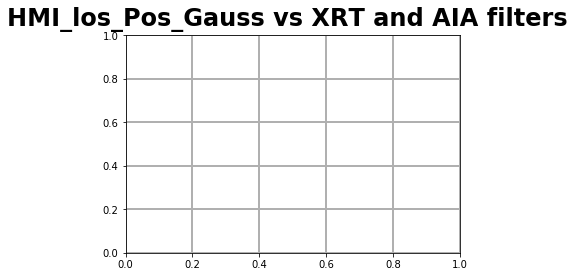

In [134]:
# Set figure
#fig, ax1 = plt.subplots(1, figsize=(15,10)) # Comment out this line if you want to hide plot

# XRT filters
lns1 = ax1.plot(HMIlosPos_newYvals, Al_Mesh_newYvals, 'r8', markersize = 5, label = 'Al_Mesh')
lns2 = ax1.plot(HMIlosPos_newYvals, Al_Poly_newYvals, 'b.', markersize = 4, label = 'Al_Poly')
lns3 = ax1.plot(HMIlosPos_newYvals, Be_Thin_newYvals, 'g*', markersize = 6, label = 'Be_Thin')

# AIA filters
lns4 = ax1.plot(HMIlosPos_newYvals, AIA94A_newYvals, 'm+', markersize = 4, label = '94A')
lns5 = ax1.plot(HMIlosPos_newYvals, AIA_FeXVIII_newYvals, 'c^', markersize = 5, label = 'FeXVIII')

ax2 = ax1.twinx()

# legend
lns = lns1+lns2+lns3+lns4+lns5
labs = [l.get_label() for l in lns]
leg = ax1.legend(lns, labs, loc=0, markerscale=3, fontsize=16)

# XRT and AIA axes formatting
ax1.set_xlabel('Gauss', fontsize=20, fontweight='bold')
ax1.set_ylabel('DN / sec', fontsize=20, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=18)
ax1.set_xscale('log')
ax1.yaxis.set_tick_params(labelsize=18)
ax1.set_yscale('log')
#ax1.set_ylim([0, 4.5e8])

# HMI y-axis formatting
ax2.set_ylabel('DN / sec', fontsize=20, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yscale('log')
ax2.set_ylim([1.5e5, 0.5e9])

plt.suptitle('HMI_los_Pos_Gauss vs XRT and AIA filters', fontsize=24, fontweight='bold')

# get the lines and texts inside legend box
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=6)
plt.setp(leg_texts, fontsize='xx-large')
plt.grid(True, linewidth=2, which='major')

plt.show()

In [135]:
#######################################################################################################################

In [136]:
#######################################################################################################################

# Time Series Plots

## Plot HMI_los_Pos_Gauss vs XRT and AIA filters

In [144]:
# Set figure
#fig, ax1 = plt.subplots(1, figsize=(15,10)) # Comment out this line if you want to hide plot

# XRT filters
lns1 = ax1.plot(Be_Thin_daterange, Al_Mesh_newYvals, 'r-', markersize = 4, label = 'Al_Mesh')
lns2 = ax1.plot(Be_Thin_daterange, Al_Poly_newYvals, 'b-', markersize = 4, label = 'Al_Poly')
lns3 = ax1.plot(Be_Thin_daterange, Be_Thin_newYvals, 'g-', markersize = 4, label = 'Be_Thin')

# AIA filters
lns4 = ax1.plot(Be_Thin_daterange, AIA94A_newYvals, 'm-', markersize = 4, label = '94A')
lns5 = ax1.plot(Be_Thin_daterange, AIA_FeXVIII_newYvals, 'c-', markersize = 4, label = 'FeXVIII')

# HMI 
ax2 = ax1.twinx()
lns6 = ax2.plot(Be_Thin_daterange, HMIlosPos_newYvals, 'tab:purple', markersize = 3, label = 'HMI_Pos_los')

# legend
lns = lns1+lns2+lns3+lns4+lns5+lns6
labs = [l.get_label() for l in lns]
leg = ax1.legend(lns, labs, loc=1, fontsize=16)

# Format date on x-axis
fig.autofmt_xdate()
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%b-%d"))

# XRT and AIA axes formatting
ax1.set_xlabel('Time [UTC]', fontsize=20, fontweight='bold')
ax1.set_ylabel('DN / sec', fontsize=20, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax1.set_yscale('log')
#ax1.set_ylim([0, 4.5e8])

# HMI y-axis formatting
ax2.set_ylabel('(HMI) Gauss', fontsize=20, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yscale('log')

plt.suptitle('HMI_los_Pos_Gauss, XRT filters, and AIA filters', fontsize=24, fontweight='bold')

# get the lines and texts inside legend box
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=6)
plt.setp(leg_texts, fontsize='xx-large')

plt.show()

<Figure size 432x288 with 0 Axes>

In [138]:
#######################################################################################################################

In [139]:
#######################################################################################################################

## Plot (ALL - NORMALIZED) HMI Total B 316/1000 G, and HMI los 316/1000 G

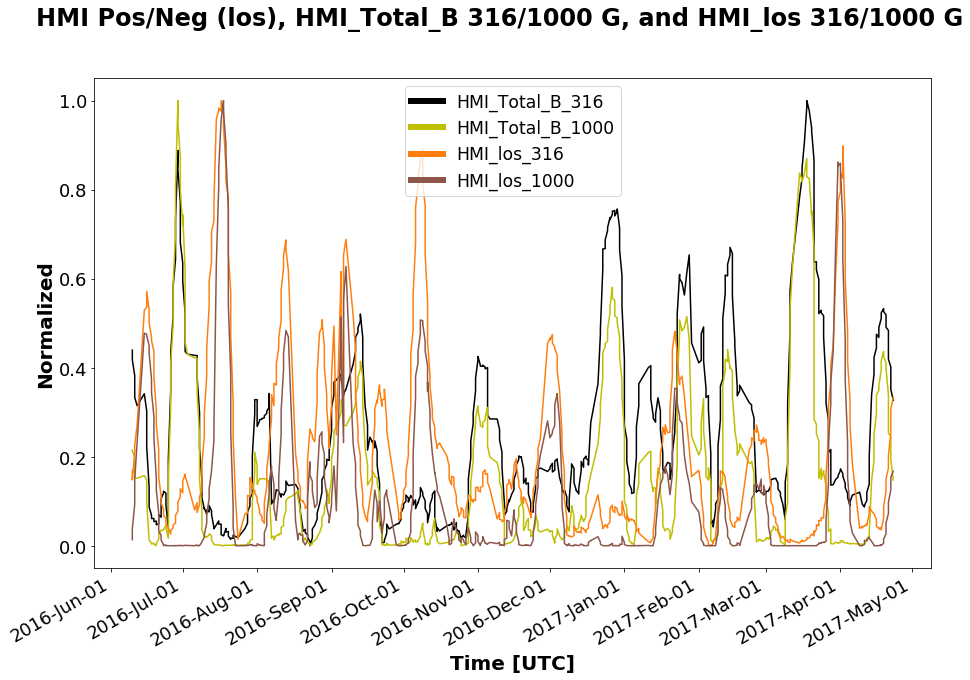

In [177]:
# Set figure
fig, ax1 = plt.subplots(1, figsize=(15,10)) # Comment out this line if you want to hide plot

# HMI Total B 316/1000 G
lns1 = ax1.plot(Be_Thin_daterange, HMI_totalB_316_Gauss_normalized, 'k-', markersize = 4, label = 'HMI_Total_B_316')
lns2 = ax1.plot(Be_Thin_daterange, HMI_totalB_1000_Gauss_normalized, 'y-', markersize = 4, label = 'HMI_Total_B_1000')

# HMI los 316/1000 G
lns3 = ax1.plot(Be_Thin_daterange, HMI_los_316_Gauss_normalized, 'tab:orange', markersize = 4, label = 'HMI_los_316')
lns4 = ax1.plot(Be_Thin_daterange, HMI_los_1000_Gauss_normalized, 'tab:brown', markersize = 4, label = 'HMI_los_1000')

# legend
lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
leg = ax1.legend(lns, labs, loc=9, fontsize=16)

# Format date on x-axis
fig.autofmt_xdate()
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%b-%d"))

# HMI y-axis formatting
ax1.set_xlabel('Time [UTC]', fontsize=20, fontweight='bold')
ax1.set_ylabel('Normalized', fontsize=20, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
#ax1.set_yscale('log')

plt.suptitle('HMI Pos/Neg (los), HMI_Total_B 316/1000 G, and HMI_los 316/1000 G', fontsize=24, fontweight='bold')

# get the lines and texts inside legend box
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=6)
plt.setp(leg_texts, fontsize='xx-large')

plt.show()

## Plot (ALL - NORMALIZED) HMI Total B 316/1000 G and XRT filters

In [148]:
# Set figure
#fig, ax1 = plt.subplots(1, figsize=(15,10)) # Comment out this line if you want to hide plot

# XRT filters
lns1 = ax1.plot(Be_Thin_daterange, XRT_Al_Mesh_normalized, 'r-', markersize = 4, label = 'Al_Mesh')
lns2 = ax1.plot(Be_Thin_daterange, XRT_Al_Poly_normalized, 'b-', markersize = 4, label = 'Al_Poly')
lns3 = ax1.plot(Be_Thin_daterange, XRT_Be_Thin_normalized, 'g-', markersize = 4, label = 'Be_Thin')

# HMI Total B 316/1000 G
lns4 = ax1.plot(Be_Thin_daterange, HMI_totalB_316_Gauss_normalized, 'k-', markersize = 4, label = 'HMI_Total_B_316')
lns5 = ax1.plot(Be_Thin_daterange, HMI_totalB_1000_Gauss_normalized, 'y-', markersize = 4, label = 'HMI_Total_B_1000')

# legend
lns = lns1+lns2+lns3+lns4+lns5
labs = [l.get_label() for l in lns]
leg = ax1.legend(lns, labs, loc=9, fontsize=16)

# Format date on x-axis
fig.autofmt_xdate()
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%b-%d"))

# XRT and AIA axes formatting
ax1.set_xlabel('Time [UTC]', fontsize=20, fontweight='bold')
ax1.set_ylabel('Normalized', fontsize=20, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
#ax1.set_yscale('log')
#ax1.set_ylim([0, 4.5e8])

plt.suptitle('HMI Total B 316/1000 G and XRT filters', fontsize=24, fontweight='bold')

# get the lines and texts inside legend box
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=6)
plt.setp(leg_texts, fontsize='xx-large')

plt.show()

<Figure size 432x288 with 0 Axes>

## Plot (ALL - NORMALIZED) HMI Total B 316/1000 G and AIA filters

In [150]:
# Set figure
#fig, ax1 = plt.subplots(1, figsize=(15,10)) # Comment out this line if you want to hide plot

# AIA filters
lns1 = ax1.plot(Be_Thin_daterange, AIA_94A_normalized, 'm-', markersize = 4, label = '94A')
lns2 = ax1.plot(Be_Thin_daterange, AIA_FeXVIII_normalized, 'c-', markersize = 4, label = 'FeXVIII')

# HMI Total B 316/1000 G

lns3 = ax1.plot(Be_Thin_daterange, HMI_totalB_316_Gauss_normalized, 'k-', markersize = 4, label = 'HMI_Total_B_316')
lns4 = ax1.plot(Be_Thin_daterange, HMI_totalB_1000_Gauss_normalized, 'y-', markersize = 4, label = 'HMI_Total_B_1000')

# legend
lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
leg = ax1.legend(lns, labs, loc=9, fontsize=16)

# Format date on x-axis
fig.autofmt_xdate()
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%b-%d"))

# XRT and AIA axes formatting
ax1.set_xlabel('Time [UTC]', fontsize=20, fontweight='bold')
ax1.set_ylabel('Normalized', fontsize=20, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
#ax1.set_yscale('log')
#ax1.set_ylim([0, 4.5e8])

plt.suptitle('HMI Total B 316/1000 G and AIA filters', fontsize=24, fontweight='bold')

# get the lines and texts inside legend box
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=6)
plt.setp(leg_texts, fontsize='xx-large')

plt.show()

<Figure size 432x288 with 0 Axes>

## Plot (ALL - NORMALIZED) HMI_los 316/1000 G and XRT filters

In [151]:
# Set figure
#fig, ax1 = plt.subplots(1, figsize=(15,10)) # Comment out this line if you want to hide plot

# XRT filters
lns1 = ax1.plot(Be_Thin_daterange, XRT_Al_Mesh_normalized, 'r-', markersize = 5, label = 'Al_Mesh')
lns2 = ax1.plot(Be_Thin_daterange, XRT_Al_Poly_normalized, 'b-', markersize = 5, label = 'Al_Poly')
lns3 = ax1.plot(Be_Thin_daterange, XRT_Be_Thin_normalized, 'g-', markersize = 5, label = 'Be_Thin')

# HMI los 316/1000 G
lns4 = ax1.plot(Be_Thin_daterange, HMI_los_316_Gauss_normalized, 'tab:orange', markersize = 5, label = 'HMI_los_316')
lns5 = ax1.plot(Be_Thin_daterange, HMI_los_1000_Gauss_normalized, 'tab:brown', markersize = 5, label = 'HMI_los_1000')

# legend
lns = lns1+lns2+lns3+lns4+lns5
labs = [l.get_label() for l in lns]
leg = ax1.legend(lns, labs, loc=9, markerscale=3, fontsize=20)

# Format date on x-axis
fig.autofmt_xdate()
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%b-%d"))

# XRT and AIA axes formatting
ax1.set_xlabel('Time [UTC]', fontsize=20, fontweight='bold')
ax1.set_ylabel('Normalized', fontsize=20, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
#ax1.set_yscale('log')
#ax1.set_ylim([0, 4.5e8])

plt.suptitle('HMI_los 316/1000 G and XRT filters', fontsize=24, fontweight='bold')

# get the lines and texts inside legend box
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=6)
plt.setp(leg_texts, fontsize='xx-large')

plt.show()

<Figure size 432x288 with 0 Axes>

## Plot (ALL - NORMALIZED) HMI_los 316/1000 G and AIA filters

In [152]:
# Set figure
#fig, ax1 = plt.subplots(1, figsize=(15,10)) # Comment out this line if you want to hide plot

# AIA filters
lns1 = ax1.plot(Be_Thin_daterange, AIA_94A_normalized, 'm-', markersize = 5, label = '94A')
lns2 = ax1.plot(Be_Thin_daterange, AIA_FeXVIII_normalized, 'c-', markersize = 5, label = 'FeXVIII')

# HMI los 316/1000 G
lns3 = ax1.plot(Be_Thin_daterange, HMI_los_316_Gauss_normalized, 'tab:orange', markersize = 5, label = 'HMI_los_316')
lns4 = ax1.plot(Be_Thin_daterange, HMI_los_1000_Gauss_normalized, 'tab:brown', markersize = 5, label = 'HMI_los_1000')

# legend
lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
leg = ax1.legend(lns, labs, loc=9, markerscale=3, fontsize=20)

# Format date on x-axis
fig.autofmt_xdate()
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%b-%d"))

# XRT and AIA axes formatting
ax1.set_xlabel('Time [UTC]', fontsize=20, fontweight='bold')
ax1.set_ylabel('Normalized', fontsize=20, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
#ax1.set_yscale('log')
#ax1.set_ylim([0, 4.5e8])

plt.suptitle('HMI_los 316/1000 G and AIA filters', fontsize=20, fontweight='bold')

# get the lines and texts inside legend box
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=6)
plt.setp(leg_texts, fontsize='xx-large')

plt.show()

<Figure size 432x288 with 0 Axes>